In [1]:
# imports 

import numpy as np 
import seaborn.objects as so
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import os, pickle, sys
import re
sys.path.append(r'/home/stud/afroehli/coding/util_scripts')
from utils_dataloading.imagenet_tree import ImagenetSemanticInfo, ImagenetSemanticSubtree


In [2]:
inet_info = ImagenetSemanticInfo()

Stop node discovered


In [3]:
# define paths to load

root_path = '/home/stud/afroehli/coding/model_results/dinov2_vits14/'

inet_1k_val_path = (root_path + 'inet_1k_val_timm_trans.pkl', 'inet_1k_val')
inet_v2_70_path = (root_path + 'inet_v2_70_timm_trans.pkl', 'inet_v2_70')
inet_v2_mf_path = (root_path + 'inet_v2_mf_timm_trans.pkl', 'inet_v2_mf')
inet_v2_top_path = (root_path + 'inet_v2_top_timm_trans.pkl', 'inet_v2_top')
inet_r_path = (root_path + 'inet_r_plus_pt_timm_trans.pkl', 'inet_r')

loading_paths = [inet_1k_val_path, inet_v2_70_path, inet_v2_top_path, inet_v2_mf_path, inet_r_path]

inet_c_basepath = root_path + 'imagenet_c'
inet_c_corruptions = os.listdir(inet_c_basepath)

In [4]:
# return dict only with cls-token from dict that holds pt-tokens + cls-token 

def cls_tokens_from_cls_plus_pt_tokens(cls_plus_pt_tokens: dict) -> dict:
    just_cls_tokens = dict()
    for class_wnid in cls_plus_pt_tokens.keys():
        just_cls_tokens[class_wnid] = [np.squeeze(cls_plus_pt[3][1]) for cls_plus_pt in cls_plus_pt_tokens[class_wnid]]

    return just_cls_tokens 

def get_cls_token_single_layer(cls_plus_pt_token: dict) -> dict: 
    just_cls_token = dict()
    for class_wnid in cls_plus_pt_token.keys():
        just_cls_token[class_wnid] = [np.squeeze(cls_plus_pt[1]) for cls_plus_pt in cls_plus_pt_token[class_wnid]]
    return just_cls_token


In [5]:
# load pre-computed embeddings 

model_results = dict()

# first all simple datasets
for load_path, dict_name in loading_paths:
    with open(load_path, 'rb') as pkl_file:
        if dict_name == 'inet_r':
            model_results[dict_name] = cls_tokens_from_cls_plus_pt_tokens(pickle.load(pkl_file))
        else:
            model_results[dict_name] = pickle.load(pkl_file)


# then all variations of imagenet-c
model_results['inet_c'] = dict()
for corruption in inet_c_corruptions:
    for sev_n in range(1, 6):
        if sev_n == 1: 
            model_results['inet_c'][corruption] = dict()

        with open(f'{inet_c_basepath}/{corruption}/sev_{sev_n}.pkl', 'rb') as pkl_file:
            inet_c_results_dict = pickle.load(pkl_file)
            wnid_list = list(inet_c_results_dict.keys())
            model_results['inet_c'][corruption][sev_n] = get_cls_token_single_layer(inet_c_results_dict)
            
            assert len(model_results['inet_c'][corruption][sev_n]) == len(wnid_list)
            for wnid in wnid_list:
                assert len(model_results['inet_c'][corruption][sev_n][wnid]) == 50 

In [6]:
# define inet-classes to be used for demonstration 

class_a = 'n07714571'
classes_b = {'L1': 'n04286575', 'C1': 'n03991062', 'C2': 'n02206856', 'C3': 'n07715103'}
class_r = 'n02100877'

# control output 

class_list = [class_a, class_r]
class_list.extend([class_b_wnid for _, class_b_wnid in list(classes_b.items())])
print([inet_info.wnid_to_classname[wnid] for wnid in class_list])

# compute mean embedding of inet-1k-val 

# whole imagenet-1k 
inet_1k_all_embeds = []
for wnid in model_results['inet_1k_val'].keys():
    inet_1k_all_embeds.extend(model_results['inet_1k_val'][wnid])

inet_1k_mean = np.mean(np.array(inet_1k_all_embeds), axis = 0)

[' cabbage', ' Irish Setter', ' spotlight', ' plant pot', ' bee', ' cauliflower']


In [7]:
def calc_l1_dist(emb_one: np.array, emb_two: np.array) -> float :
    return np.sum(np.abs(emb_one - emb_two))

def count_dims_nearer_than_comp_embedding(emb_fixed: np.array, emb_class: np.array, emb_comp: np.array) -> float: 
    return (np.abs(emb_class - emb_fixed) < np.abs(emb_comp - emb_fixed)).tolist().count(True) 

def count_dims_within_stddev(emb_fixed_mean: np.array, emb_fixed_stddev: np.array, emb_class: np.array) -> float:
    return (np.abs(emb_fixed_mean - emb_class) <= emb_fixed_stddev).tolist().count(True) 

def count_dims_exclusive_within_stddev(emb_fixed_mean: np.array, emb_fixed_stddev: np.array, emb_class_in: np.array, emb_class_out: np.array) -> float:
    abs_dist_in = np.abs(emb_class_in - emb_fixed_mean)
    abs_dist_out = np.abs(emb_class_out - emb_fixed_mean)
    return np.logical_and((abs_dist_in <= emb_fixed_stddev), (abs_dist_out >= emb_fixed_stddev)).tolist().count(True)

      l1-dist     class-name                            dataset class-split  \
0  543.318848      spotlight                        Imagenet-1k     class-B   
1  753.198486   Irish Setter                        Imagenet-1k     class-R   
2  182.466797        cabbage                     Imagenet-V2-70    class-A'   
3  405.508972        cabbage                         Imagenet-R    class-A'   
4  164.474304        cabbage  ImageNet-C\nGaussian Blur - Sev-1    class-A'   
5  593.614990        cabbage  ImageNet-C\nGaussian Blur - Sev-5    class-A'   

                                nameAndDataset  
0                       spotlight\nImagenet-1k  
1                    Irish Setter\nImagenet-1k  
2                      cabbage\nImagenet-V2-70  
3                          cabbage\nImagenet-R  
4   cabbage\nImageNet-C\nGaussian Blur - Sev-1  
5   cabbage\nImageNet-C\nGaussian Blur - Sev-5  
Imagenet-1k-mean-dist: 517.4177856445312


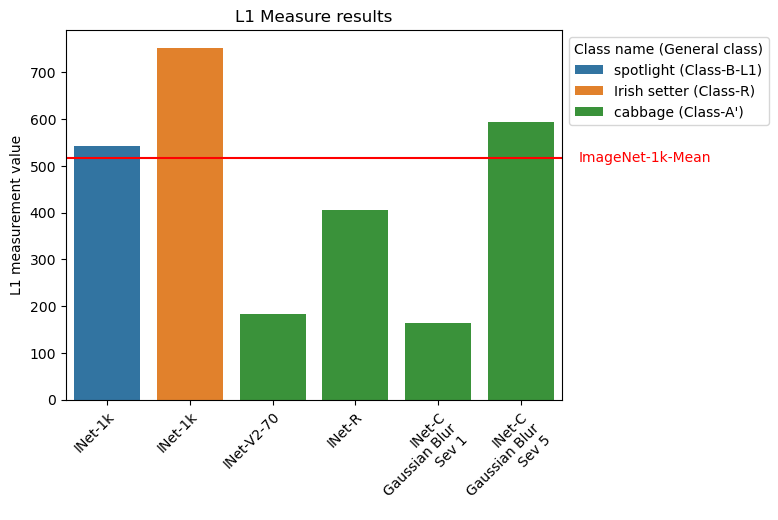

In [32]:
# compute l1-results

class_a_mean = np.mean(np.array(model_results['inet_1k_val'][class_a]), axis=0)
class_a_stddev = np.std(np.array(model_results['inet_1k_val'][class_a]), axis=0)
class_b_l1_mean = np.mean(np.array(model_results['inet_1k_val'][classes_b['L1']]), axis=0)
class_b_c1_mean = np.mean(np.array(model_results['inet_1k_val'][classes_b['C1']]), axis=0)
class_b_c2_mean = np.mean(np.array(model_results['inet_1k_val'][classes_b['C2']]), axis=0)
class_b_c3_mean = np.mean(np.array(model_results['inet_1k_val'][classes_b['C3']]), axis=0)
class_r_mean = np.mean(np.array(model_results['inet_1k_val'][class_r]), axis=0)

class_a_p_mean = { 
'inet_v2_70': np.mean(np.array(model_results['inet_v2_70'][class_a]), axis=0),
'inet_v2_mf': np.mean(np.array(model_results['inet_v2_70'][class_a]), axis=0),
'inet_v2_top': np.mean(np.array(model_results['inet_v2_top'][class_a]), axis=0),
'inet_r': np.mean(np.array(model_results['inet_r'][class_a]), axis=0),
'inet_c_gb_sev_1': np.mean(np.array(model_results['inet_c']['gaussian_blur'][1][class_a]), axis=0),
'inet_c_gb_sev_5': np.mean(np.array(model_results['inet_c']['gaussian_blur'][5][class_a]), axis=0)}

inet_1k_mean_dist = calc_l1_dist(inet_1k_mean, class_a_mean)
class_b_l1_dist = calc_l1_dist(class_b_l1_mean, class_a_mean)
class_r_l1_dist = calc_l1_dist(class_r_mean, class_a_mean)

ood_dsets = [ 'inet_v2_70', 'inet_r', 'inet_c_gb_sev_1', 'inet_c_gb_sev_5']
class_a_p_l1_dist = dict()
for dset in class_a_p_mean.keys():
    if dset in ood_dsets:
        class_a_p_l1_dist[dset] = calc_l1_dist(class_a_p_mean[dset], class_a_mean)

inet_c_l1_dists = {(1, 'Sev-1'): [], (5, 'Sev-5'): []}

# for sev, sev_name in inet_c_l1_dists.keys():
#     # first get list of all mean embeddings per corruption type 
#     mean_embed_per_cor = [np.mean(np.array(model_results['inet_c'][cor_type][sev][class_a]), axis=0) for cor_type in model_results['inet_c'].keys()]
#     # next, for each mean_embed calc l1-dist to class-a 
#     for mean_embed in mean_embed_per_cor: 
#         inet_c_l1_dists[(sev, sev_name)].append(calc_l1_dist(mean_embed, class_a_mean))


# DataFrame
# distance-value; class-name; dataset; class-split 
inet_class_names = list(zip([class_b_l1_dist, class_r_l1_dist], [inet_info.wnid_to_classname[wnid] for wnid in [classes_b['L1'], class_r]], ['Imagenet-1k' for i in range(2)], ['class-B', 'class-R']))
inet_class_names.extend(zip([class_a_p_l1_dist[dset] for dset in class_a_p_l1_dist.keys()], [inet_info.wnid_to_classname[class_a] for i in range(4)], [ 'Imagenet-V2-70', 'Imagenet-R',
'ImageNet-C\nGaussian Blur - Sev-1', 'ImageNet-C\nGaussian Blur - Sev-5'],
                            ['class-A\'' for i in range(4)]))
# for sev, sev_name in inet_c_l1_dists.keys():
#     inet_class_names.extend(zip(inet_c_l1_dists[(sev, sev_name)], 
#     [inet_info.wnid_to_classname[class_a] for i in range(len(inet_c_l1_dists[(sev, sev_name)]))], 
#     [f'Imagenet-C-{sev_name}' for i in range(len(inet_c_l1_dists[(sev, sev_name)]))],
#     ['class-A\'' for i in range(len(inet_c_l1_dists[(sev, sev_name)]))]))

l1_dist_df = pd.DataFrame(data=inet_class_names, columns=['l1-dist', 'class-name', 'dataset', 'class-split'])
l1_dist_df = l1_dist_df.assign(nameAndDataset = lambda x : pd.Series([f'{row['class-name']}\n{row['dataset']}' for _, row in x.iterrows()]))
print(l1_dist_df.head(n=10))
print(f'Imagenet-1k-mean-dist: {inet_1k_mean_dist}')

# plot 
sns_plot = sns.barplot(data=l1_dist_df, x='nameAndDataset', y='l1-dist', hue='class-split')
handles, labels = sns_plot.get_legend_handles_labels()
sns_plot.legend(handles, ['spotlight (Class-B-L1)', 'Irish setter (Class-R)', 'cabbage (Class-A\')'], title='Class name (General class)',
                bbox_to_anchor=(1, 1), loc='upper left')
# sns_plot.set_xlabel(['a', 'b', 'c', 'd', 'e', 'f'])
sns_plot.set_xticks([0, 1, 2, 3, 4, 5], ['INet-1k', 'INet-1k', 'INet-V2-70', 'INet-R', 'INet-C\nGaussian Blur\nSev 1', 'INet-C\nGaussian Blur\nSev 5'])
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.axhline(y=inet_1k_mean_dist, color='r')
plt.text(x=5.7, y=inet_1k_mean_dist, verticalalignment='center', s='ImageNet-1k-Mean', color='r')
sns_plot.set(xlabel='', ylabel='L1 measurement value')
plt.title('L1 Measure results')
plt.savefig('/home/stud/afroehli/coding/dinov2_ood/diagrams/example_diagram_l1.png', bbox_inches='tight')



   c1-value     class-name                            dataset class-split  \
0       190      plant pot                        ImageNet-1k     class-B   
1       134   Irish Setter                        ImageNet-1k     class-R   
2       300        cabbage                         Imagenet-R    class-A'   
3       222        cabbage                     Imagenet-V2-70    class-A'   
4       308        cabbage  ImageNet-C\nGaussian Blur - Sev-1    class-A'   
5       169        cabbage  ImageNet-C\nGaussian Blur - Sev-5    class-A'   

   c1_value_rel                               nameAndDataset  
0     49.479167                       plant pot\nImageNet-1k  
1     34.895833                    Irish Setter\nImageNet-1k  
2     78.125000                          cabbage\nImagenet-R  
3     57.812500                      cabbage\nImagenet-V2-70  
4     80.208333   cabbage\nImageNet-C\nGaussian Blur - Sev-1  
5     44.010417   cabbage\nImageNet-C\nGaussian Blur - Sev-5  


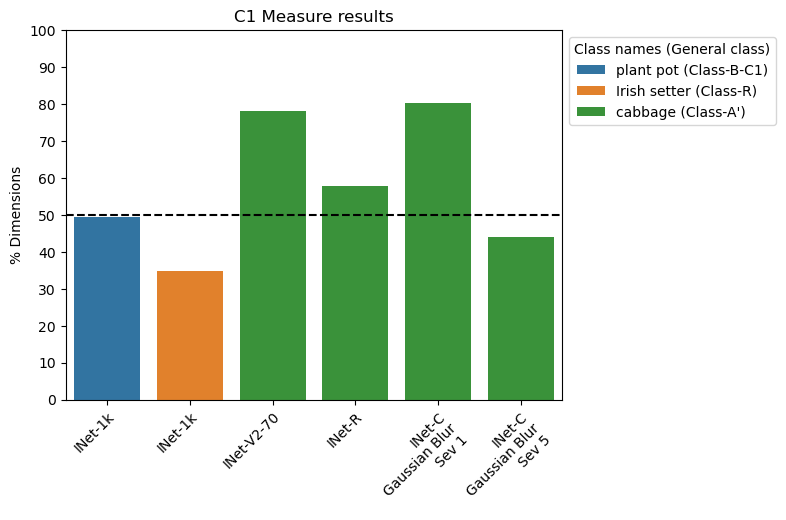

In [33]:
# compute C1 results 

class_b_c1_dist = count_dims_nearer_than_comp_embedding(class_a_mean, class_b_c1_mean, inet_1k_mean)
class_r_c1_dist = count_dims_nearer_than_comp_embedding(class_a_mean, class_r_mean, inet_1k_mean)

ood_dsets = [ 'inet_v2_70', 'inet_r', 'inet_c_gb_sev_1', 'inet_c_gb_sev_5']
class_a_p_c1_dist = dict()
for dset in class_a_p_mean.keys():
    if dset in ood_dsets:
        class_a_p_c1_dist[dset] = count_dims_nearer_than_comp_embedding(class_a_mean, class_a_p_mean[dset], inet_1k_mean)

inet_c_c1_dists = {(2, 'Sev-2'): [], (3, 'Sev-3'): []}
# for sev in inet_c_c1_dists.keys():
#     inet_c_mean_embeds = [np.mean(np.array(model_results['inet_c'][cor_type][sev[0]][class_a]), axis=0) for cor_type in model_results['inet_c'].keys()]
#     for inet_c_mean_embed in inet_c_mean_embeds:
#         inet_c_c1_dists[sev].append(count_dims_nearer_than_comp_embedding(class_a_mean, inet_c_mean_embed, inet_1k_mean))

# build DataFrame with columns: c1-value, class-name, dataset, class-split, class-name-and-dataset 
c1_measure_data = list(zip([class_b_c1_dist, class_r_c1_dist], [inet_info.wnid_to_classname[wnid] for wnid in [classes_b['C1'], class_r]],
['ImageNet-1k' for i in range(2)], ['class-B', 'class-R']))
c1_measure_data.extend(zip([class_a_p_c1_dist[dset] for dset in class_a_p_c1_dist.keys()], [inet_info.wnid_to_classname[class_a] for i in range(4)], 
['Imagenet-R', 'Imagenet-V2-70', 'ImageNet-C\nGaussian Blur - Sev-1', 'ImageNet-C\nGaussian Blur - Sev-5'], ['class-A\'' for i in range(4)]))
# for sev in inet_c_c1_dists.keys():
#     c1_measure_data.extend(zip(inet_c_c1_dists[sev], [inet_info.wnid_to_classname[class_a] for i in range(15)], [f'Imagenet-C-{sev[1]}' for i in range(15)],
#     ['class-A\'' for i in range(15)]))

c1_measure_df = pd.DataFrame(data=c1_measure_data, columns=['c1-value', 'class-name', 'dataset', 'class-split'])
c1_measure_df = c1_measure_df.assign(c1_value_rel = lambda x: pd.Series([(row['c1-value'] / 384) * 100 for _, row in x.iterrows()]))
c1_measure_df = c1_measure_df.assign(nameAndDataset = lambda x : pd.Series([f'{row['class-name']}\n{row['dataset']}' for _, row in x.iterrows()]))
print(c1_measure_df.head(n=10))

# plot
sns_plot = sns.barplot(data=c1_measure_df, x='nameAndDataset', y='c1_value_rel', hue='class-split')
handles, labels = sns_plot.get_legend_handles_labels()
sns_plot.legend(handles, ['plant pot (Class-B-C1)', 'Irish setter (Class-R)', 'cabbage (Class-A\')'], title='Class names (General class)', 
                bbox_to_anchor=(1, 1), loc='upper left')
plt.ylim(0, 100)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
# sns.move_legend(sns_plot, 'upper left', bbox_to_anchor=(1,1))
sns_plot.set(xlabel='')
sns_plot.set_ylabel('% Dimensions')
plt.axhline(y=50, color='black', linestyle='--')
sns_plot.set_xticks([0, 1, 2, 3, 4, 5], ['INet-1k', 'INet-1k', 'INet-V2-70', 'INet-R', 'INet-C\nGaussian Blur\nSev 1', 'INet-C\nGaussian Blur\nSev 5'])
sns_plot.set_yticks(np.arange(0, 101, 10))
plt.title('C1 Measure results')
plt.savefig('/home/stud/afroehli/coding/dinov2_ood/diagrams/example_diagram_c1.png', bbox_inches='tight')

In [12]:
pat_first = re.compile('i.*not.*')
pat_second = re.compile('not.*and.*')
pat_both = re.compile('i.*and.*')
pat_none = re.compile('not.*not.*')

def calculate_in_stddev_stats(class_X_mean: np.array, store_dict: dict, class_a_mean, class_a_stddev, inet_1k_mean):

        inet_1k_class_a_dist = np.abs(inet_1k_mean - class_a_mean)
        class_X_class_a_dist = np.abs(class_X_mean - class_a_mean)

        for log_case in ['in_not_inet_mean', 'in_and_inet_mean', 'not_in_and_inet_mean', 'not_in_not_inet_mean']:


            if pat_first.fullmatch(log_case):
                store_dict[log_case] = np.logical_and((class_X_class_a_dist <= class_a_stddev), 
                                                                            (inet_1k_class_a_dist > class_a_stddev)).tolist().count(True)
            elif pat_second.fullmatch(log_case):
                store_dict[log_case] = np.logical_and((class_X_class_a_dist > class_a_stddev), 
                                                                (inet_1k_class_a_dist <= class_a_stddev)).tolist().count(True)
            elif pat_both.fullmatch(log_case):
                store_dict[log_case] = np.logical_and((class_X_class_a_dist <= class_a_stddev), 
                                                                (inet_1k_class_a_dist <= class_a_stddev)).tolist().count(True)
            elif pat_none.fullmatch(log_case):
                store_dict[log_case] = np.logical_and((class_X_class_a_dist > class_a_stddev), 
                                                                (inet_1k_class_a_dist > class_a_stddev)).tolist().count(True)
            else:
                raise ValueError(f'Logical case *{log_case}* was not matched')

{'in_not_inet_mean': [7.8125, 16.927083333333336, 9.635416666666668, 31.770833333333332, 20.572916666666664, 23.177083333333336, 11.71875], 'in_and_inet_mean': [58.072916666666664, 45.57291666666667, 39.32291666666667, 67.70833333333334, 57.8125, 59.635416666666664, 43.22916666666667], 'not_in_not_inet_mean': [34.114583333333336, 37.5, 51.041666666666664, 0.5208333333333333, 21.614583333333336, 17.1875, 45.052083333333336]}


/tmp/ipykernel_1716856/117056092.py:122: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=1)


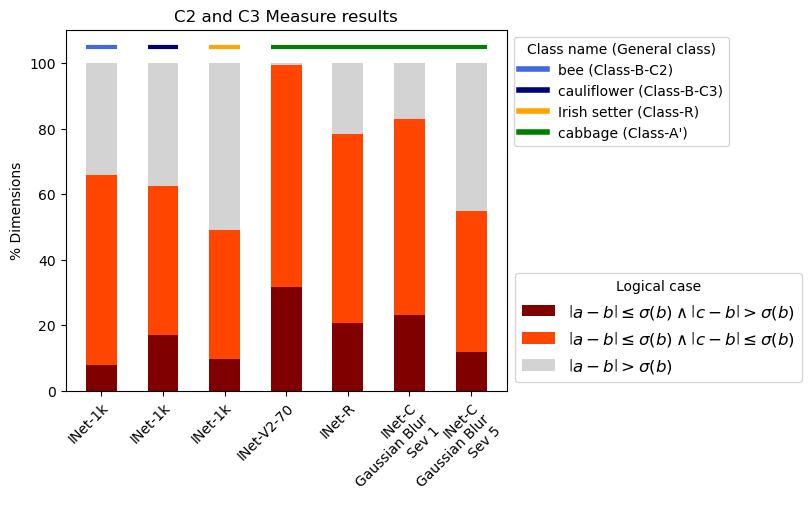

In [41]:
# compute C2 and C3 results 

class_b_c2 = classes_b['C2']
class_b_c3 = classes_b['C3']
class_b_c2_dist = dict()
class_b_c3_dist = dict()
class_r_c2_c3_dist = dict()

calculate_in_stddev_stats(class_b_c2_mean, class_b_c2_dist, class_a_mean, class_a_stddev, inet_1k_mean)
calculate_in_stddev_stats(class_b_c3_mean, class_b_c3_dist, class_a_mean, class_a_stddev, inet_1k_mean)
calculate_in_stddev_stats(class_r_mean, class_r_c2_c3_dist, class_a_mean, class_a_stddev, inet_1k_mean)

ood_dsets = ['inet_v2_70', 'inet_r']
class_a_p_c2_c3_dist = dict()
for dset in class_a_p_mean.keys():
    if dset in ood_dsets:
        class_a_p_c2_c3_dist[dset] = dict()
        calculate_in_stddev_stats(class_a_p_mean[dset], class_a_p_c2_c3_dist[dset], class_a_mean, class_a_stddev, inet_1k_mean)

corr_tpye = 'glass_blur'
inet_c2_c3_dist = {(1, 'Sev-1'): {'mean': np.mean(np.array(model_results['inet_c'][corr_tpye][1][class_a]), axis=0),
                                    'c2_c3_dist': dict()},
                    (4, 'Sev-4'): {'mean': np.mean(np.array(model_results['inet_c'][corr_tpye][4][class_a]), axis=0),
                                    'c2_c3_dist': dict()}}

for sev in inet_c2_c3_dist.keys():
    calculate_in_stddev_stats(inet_c2_c3_dist[sev]['mean'], inet_c2_c3_dist[sev]['c2_c3_dist'], class_a_mean, class_a_stddev, inet_1k_mean)

# DataFrame 
# columns: vals, log_case, class-name, dataset, class-split
# for each class, there are 4 values, what means 4 rows 

stacked_graph_data = []
for res_dict, class_wnid, class_split in [(class_b_c2_dist, class_b_c2, 'Class-B-C2'),
                                            (class_b_c3_dist, class_b_c3, 'Class-B-C3'),
                                            (class_r_c2_c3_dist, class_r, 'Class-R')]:
    stacked_graph_data.extend(list(zip([res_dict[log_case] for log_case in res_dict.keys()], 
                            list(res_dict.keys()),
                            [inet_info.wnid_to_classname[class_wnid] for i in range(4)],
                            ['Imagenet-1k' for i in range(4)],
                            [class_split for i in range(4)]
                            )))

for dset in class_a_p_c2_c3_dist.keys():
    res_dict = class_a_p_c2_c3_dist[dset]
    if dset == 'inet_r':
        dset_name = 'Imagenet-R'
    else:
        dset_name = 'Imagenet-V2-70'
    stacked_graph_data.extend(list(zip([res_dict[log_case] for log_case in res_dict.keys()], 
                            list(res_dict.keys()),
                            [inet_info.wnid_to_classname[class_a] for i in range(4)],
                            [dset_name for i in range(4)],
                            ['class-A\'' for i in range(4)]
                            )))

for sev in inet_c2_c3_dist.keys():
    res_dict = inet_c2_c3_dist[sev]['c2_c3_dist']
    stacked_graph_data.extend(list(zip([res_dict[log_case] for log_case in res_dict.keys()], 
                        list(res_dict.keys()),
                        [inet_info.wnid_to_classname[class_a] for i in range(4)],
                        [f'Imagenet-C-{sev[1]}' for i in range(4)],
                        ['class-A\'' for i in range(4)]
                        )))
    
test_df = pd.DataFrame(data=stacked_graph_data, columns=['vals', 'log_case', 'class-name', 'dataset', 'class-split'])
test_df = test_df.assign(nameAndDataset = lambda x : pd.Series([f'{row['class-name']}\n{row['dataset']}' for _, row in x.iterrows()]))
test_df['vals'] = test_df['vals'] / 384 
x_label_list = test_df['nameAndDataset'].unique().tolist()
class_splits = x_label_list


# create dict with form
# {log_case: c2-val, c3-val, r-val}
res_list = [class_b_c2_dist, class_b_c3_dist, class_r_c2_c3_dist]
res_list.extend([class_a_p_c2_c3_dist[dset] for dset in class_a_p_c2_c3_dist.keys()])
res_list.extend([inet_c2_c3_dist[sev]['c2_c3_dist'] for sev in inet_c2_c3_dist.keys()])
weight_counts = dict()
for log_case in class_b_c2_dist.keys():
    weight_counts[log_case] = []
    for res_dict in res_list:
        weight_counts[log_case].append((res_dict[log_case] / 384 * 100))

# 'in_not_inet_mean', 'in_and_inet_mean', 'not_in_and_inet_mean', 'not_in_not_inet_mean'
weight_counts_2 = {'in_not_inet_mean': weight_counts['in_not_inet_mean'], 'in_and_inet_mean': weight_counts['in_and_inet_mean'],
'not_in_not_inet_mean': [a + b for a, b in zip(weight_counts['not_in_and_inet_mean'], weight_counts['not_in_not_inet_mean'])]}
print(weight_counts_2)
width = 0.5

fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
bottom = np.zeros(7)

for color, (log_case, weight_count) in zip(['maroon', 'orangered', 'lightgrey'], weight_counts_2.items()):
    p = ax.bar(class_splits, weight_count, width, label=log_case, bottom=bottom, color=color)
    bottom += weight_count

ax.set_title("C2 and C3 Measure results")
# add legends
handles, legend = ax.get_legend_handles_labels()
handles_1 = [
    Line2D([0], [0], color='royalblue', lw=4, label='Class-B'),
    Line2D([0], [0], color='navy', lw=4, label='Class-B'),
    Line2D([0], [0], color='orange', lw=4, label='Class-R'),
    Line2D([0], [0], color='green', lw=4, label='Class-A\''),
]
leg_1 = ax.legend(handles_1, ['bee (Class-B-C2)', 'cauliflower (Class-B-C3)', 'Irish setter (Class-R)', 'cabbage (Class-A\')'], bbox_to_anchor=(1, 1), 
title='Class name (General class)', loc='upper left')
ax.add_artist(leg_1)
leg_2 = ax.legend(handles, [r'$\left| a - b \right| \leq \sigma(b) \wedge \left| c - b \right| > \sigma(b) $',
                    r'$\left| a - b \right| \leq \sigma(b) \wedge \left| c - b \right| \leq \sigma(b) $',
                    r'$\left| a - b \right| > \sigma(b)$'], bbox_to_anchor=(1, 0), 
                    loc='lower left', title='Logical case', fontsize=12)

plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
ax.hlines(105, -0.25, 0.25, color='royalblue', linewidth=3)
ax.hlines(105, 0.75, 1.25, color='navy', linewidth=3)
ax.hlines(105, 1.75, 2.25, color='orange', linewidth=3)
ax.hlines(105, 2.75, 6.25, color='green', linewidth=3)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6], ['INet-1k', 'INet-1k', 'INet-1k', 'INet-V2-70', 'INet-R', 'INet-C\nGaussian Blur\nSev 1', 'INet-C\nGaussian Blur\nSev 5'])

plt.ylabel('% Dimensions')
plt.subplots_adjust(bottom=1)
plt.savefig('/home/stud/afroehli/coding/dinov2_ood/diagrams/example_diagram_c2_c3.png', bbox_inches='tight')
plt.show()

    